# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

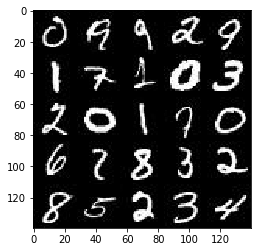

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

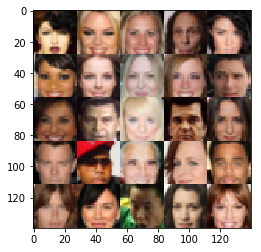

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name="realInput")
    fake_input = tf.placeholder(tf.float32,(None,z_dim),name="fakeInput")
    lr = tf.placeholder(tf.float32, name="learningRate")

    return real_input, fake_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/carnd/anaconda3/envs/dlenvclone/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/carnd/anaconda3/envs/dlenvclone/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/carnd/anaconda3/envs/dlenvclone/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/carnd/anaconda3/envs/dlenvclone/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/carnd/anaconda3/envs/dlenvclone/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):

        x = tf.layers.conv2d(images,128,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.maximum(x*alpha,x)
                
        x1 = tf.layers.conv2d(x,256,5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.layers.batch_normalization(x1)
        x1 = tf.maximum(x1*alpha,x1)
        x1 = tf.nn.dropout(x1,0.6)
                
        x2 = tf.layers.conv2d(x1, 512, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2*alpha,x2)
        x2 = tf.nn.dropout(x2,0.6)
                
        x3 = tf.layers.conv2d(x2, 1024, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3,0.6)
        print("x3 shape:::", x3.get_shape())
        # 4x4x1024
        
        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*1024))
        
        #flat = tf.reshape(x1,(-1,7*7*256))        
        logits = tf.layers.dense(flat,1,activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

x3 shape::: (?, 4, 4, 1024)
x3 shape::: (?, 4, 4, 1024)
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2

    with tf.variable_scope('generator',reuse = not is_train):
    
        #x = tf.layers.dense(z,(7*7*256),activation=None)
        x = tf.layers.dense(z, 2*2*1024,activation=None)
        
              
        x1 = tf.reshape(x,(-1,2,2,1024))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(alpha*x1,x1)
        x1 = tf.nn.dropout(x1, 0.6)
                
        '''x2 = tf.layers.conv2d_transpose(x1,256,5,strides=2,padding='same')
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = tf.maximum(alpha*x2,x2)'''
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.6)        
        
        x_3 = tf.layers.conv2d_transpose(x2, 256, 4, strides=1, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x_3 = tf.layers.batch_normalization(x_3, training=is_train)
        x_3 = tf.maximum(alpha * x_3, x_3)
        x_3 = tf.nn.dropout(x_3, 0.6)
                
        x3 = tf.layers.conv2d_transpose(x_3,128,5,strides=2,padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3,training=is_train)
        x3 = tf.maximum(alpha*x3,x3)
        x3 = tf.nn.dropout(x3, 0.6)
        
        logits = tf.layers.conv2d_transpose(x3,out_channel_dim,5,strides=2,padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        print("logits shape:::", logits.get_shape())
        out = tf.tanh(logits)   
    
        return out



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

logits shape::: (?, 28, 28, 5)
logits shape::: (?, 28, 28, 5)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    smooth = 0.1

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

logits shape::: (?, 28, 28, 4)
x3 shape::: (?, 4, 4, 1024)
x3 shape::: (?, 4, 4, 1024)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(generator(input_z, out_channel_dim, is_train=False), feed_dict={input_z: example_z})
    

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
  

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print(data_shape)
    tf.reset_default_graph()
    image_width = data_shape[1]
    image_height = data_shape[2]
    input_real, input_z, lr = model_inputs(image_width, image_height, data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    saver = tf.train.Saver()
    steps = 0
    
    print_every=20
    show_every = 200
    
    losses = []    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real:batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real:batch_images, input_z: batch_z, lr:learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    _ = show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    
                    
            saver.save(sess, './checkpoints/generator.ckpt')




### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
logits shape::: (?, 28, 28, 1)
x3 shape::: (?, 4, 4, 1024)
x3 shape::: (?, 4, 4, 1024)
Epoch 1/2... Discriminator Loss: 5.4198... Generator Loss: 5.7352
Epoch 1/2... Discriminator Loss: 3.4065... Generator Loss: 0.2370
Epoch 1/2... Discriminator Loss: 1.1683... Generator Loss: 1.0070
Epoch 1/2... Discriminator Loss: 1.5672... Generator Loss: 2.6048
Epoch 1/2... Discriminator Loss: 1.1607... Generator Loss: 1.8013
Epoch 1/2... Discriminator Loss: 2.1307... Generator Loss: 1.3460
Epoch 1/2... Discriminator Loss: 1.9293... Generator Loss: 1.6721
Epoch 1/2... Discriminator Loss: 1.4128... Generator Loss: 2.6648
Epoch 1/2... Discriminator Loss: 0.8561... Generator Loss: 1.5303
Epoch 1/2... Discriminator Loss: 0.8575... Generator Loss: 3.1250
logits shape::: (?, 28, 28, 1)


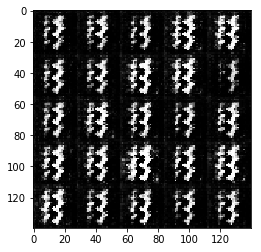

Epoch 1/2... Discriminator Loss: 0.8229... Generator Loss: 1.6658
Epoch 1/2... Discriminator Loss: 1.7546... Generator Loss: 4.7888
Epoch 1/2... Discriminator Loss: 2.3929... Generator Loss: 5.7726
Epoch 1/2... Discriminator Loss: 1.4526... Generator Loss: 3.6463
Epoch 1/2... Discriminator Loss: 1.4645... Generator Loss: 5.4268
Epoch 1/2... Discriminator Loss: 1.7405... Generator Loss: 5.6381
Epoch 1/2... Discriminator Loss: 1.2880... Generator Loss: 1.0623
Epoch 1/2... Discriminator Loss: 1.2527... Generator Loss: 0.9591
Epoch 1/2... Discriminator Loss: 1.9387... Generator Loss: 0.3646
Epoch 1/2... Discriminator Loss: 1.2790... Generator Loss: 1.1357
logits shape::: (?, 28, 28, 1)


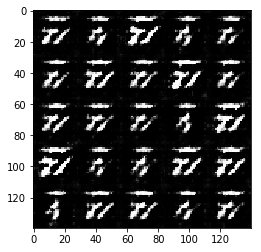

Epoch 1/2... Discriminator Loss: 0.9161... Generator Loss: 1.5537
Epoch 1/2... Discriminator Loss: 0.6507... Generator Loss: 2.5570
Epoch 1/2... Discriminator Loss: 1.2102... Generator Loss: 1.3238
Epoch 1/2... Discriminator Loss: 1.1330... Generator Loss: 2.0986
Epoch 1/2... Discriminator Loss: 1.3151... Generator Loss: 4.5925
Epoch 1/2... Discriminator Loss: 1.9359... Generator Loss: 0.9074
Epoch 1/2... Discriminator Loss: 1.0322... Generator Loss: 1.6221
Epoch 1/2... Discriminator Loss: 0.8635... Generator Loss: 1.4090
Epoch 1/2... Discriminator Loss: 1.1516... Generator Loss: 1.8240
Epoch 1/2... Discriminator Loss: 1.2408... Generator Loss: 1.6287
logits shape::: (?, 28, 28, 1)


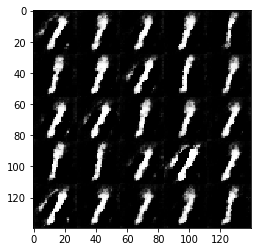

Epoch 1/2... Discriminator Loss: 0.9887... Generator Loss: 2.2824
Epoch 1/2... Discriminator Loss: 1.6338... Generator Loss: 3.6651
Epoch 1/2... Discriminator Loss: 1.7807... Generator Loss: 0.6691
Epoch 1/2... Discriminator Loss: 1.1178... Generator Loss: 1.8188
Epoch 1/2... Discriminator Loss: 1.3467... Generator Loss: 1.0295
Epoch 1/2... Discriminator Loss: 0.8191... Generator Loss: 2.6099
Epoch 1/2... Discriminator Loss: 1.1615... Generator Loss: 0.9787
Epoch 1/2... Discriminator Loss: 1.0705... Generator Loss: 1.9236
Epoch 1/2... Discriminator Loss: 0.8055... Generator Loss: 1.9467
Epoch 1/2... Discriminator Loss: 0.5621... Generator Loss: 2.7166
logits shape::: (?, 28, 28, 1)


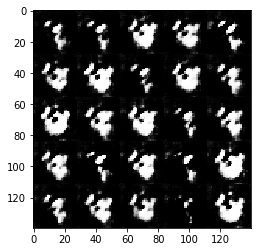

Epoch 1/2... Discriminator Loss: 0.9141... Generator Loss: 3.1782
Epoch 1/2... Discriminator Loss: 0.7968... Generator Loss: 1.8673
Epoch 1/2... Discriminator Loss: 1.0767... Generator Loss: 1.0205
Epoch 1/2... Discriminator Loss: 1.8957... Generator Loss: 4.6479
Epoch 1/2... Discriminator Loss: 0.6367... Generator Loss: 2.9458
Epoch 1/2... Discriminator Loss: 1.1444... Generator Loss: 2.1839
Epoch 2/2... Discriminator Loss: 0.5011... Generator Loss: 2.9348
Epoch 2/2... Discriminator Loss: 0.9943... Generator Loss: 1.4460
Epoch 2/2... Discriminator Loss: 1.1754... Generator Loss: 1.3454
Epoch 2/2... Discriminator Loss: 1.0541... Generator Loss: 1.3484
logits shape::: (?, 28, 28, 1)


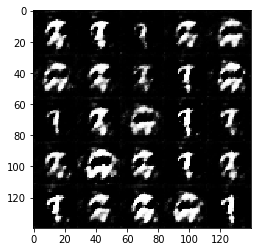

Epoch 2/2... Discriminator Loss: 0.7981... Generator Loss: 1.7367
Epoch 2/2... Discriminator Loss: 0.6270... Generator Loss: 3.2010
Epoch 2/2... Discriminator Loss: 0.7236... Generator Loss: 1.8590
Epoch 2/2... Discriminator Loss: 0.8433... Generator Loss: 1.8291
Epoch 2/2... Discriminator Loss: 0.7117... Generator Loss: 1.7381
Epoch 2/2... Discriminator Loss: 0.6508... Generator Loss: 2.8745
Epoch 2/2... Discriminator Loss: 0.5149... Generator Loss: 4.0024
Epoch 2/2... Discriminator Loss: 0.9045... Generator Loss: 1.5371
Epoch 2/2... Discriminator Loss: 1.3052... Generator Loss: 0.6655
Epoch 2/2... Discriminator Loss: 0.9554... Generator Loss: 1.2814
logits shape::: (?, 28, 28, 1)


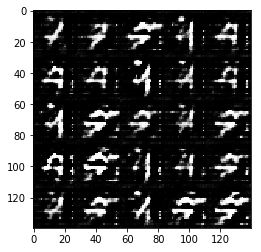

Epoch 2/2... Discriminator Loss: 0.8265... Generator Loss: 3.1999
Epoch 2/2... Discriminator Loss: 0.8309... Generator Loss: 4.4999
Epoch 2/2... Discriminator Loss: 0.8036... Generator Loss: 1.8801
Epoch 2/2... Discriminator Loss: 1.4313... Generator Loss: 4.1948
Epoch 2/2... Discriminator Loss: 0.6184... Generator Loss: 2.0465
Epoch 2/2... Discriminator Loss: 0.8520... Generator Loss: 1.3372
Epoch 2/2... Discriminator Loss: 1.0452... Generator Loss: 1.7755
Epoch 2/2... Discriminator Loss: 1.1762... Generator Loss: 4.1481
Epoch 2/2... Discriminator Loss: 0.8697... Generator Loss: 1.2116
Epoch 2/2... Discriminator Loss: 0.9151... Generator Loss: 1.5549
logits shape::: (?, 28, 28, 1)


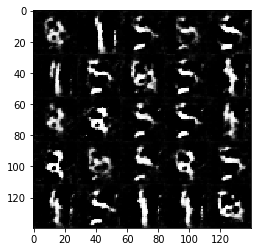

Epoch 2/2... Discriminator Loss: 0.8653... Generator Loss: 3.0476
Epoch 2/2... Discriminator Loss: 0.7540... Generator Loss: 2.4374
Epoch 2/2... Discriminator Loss: 0.9507... Generator Loss: 3.3690
Epoch 2/2... Discriminator Loss: 0.6268... Generator Loss: 2.6033
Epoch 2/2... Discriminator Loss: 0.8035... Generator Loss: 1.3151
Epoch 2/2... Discriminator Loss: 1.0808... Generator Loss: 1.8938
Epoch 2/2... Discriminator Loss: 0.8815... Generator Loss: 3.6579
Epoch 2/2... Discriminator Loss: 0.8271... Generator Loss: 2.5098
Epoch 2/2... Discriminator Loss: 0.8153... Generator Loss: 1.5759
Epoch 2/2... Discriminator Loss: 1.0209... Generator Loss: 1.6327
logits shape::: (?, 28, 28, 1)


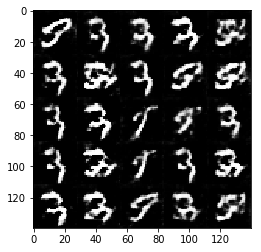

Epoch 2/2... Discriminator Loss: 1.0576... Generator Loss: 2.2898
Epoch 2/2... Discriminator Loss: 0.7318... Generator Loss: 1.6879
Epoch 2/2... Discriminator Loss: 0.9354... Generator Loss: 1.0352
Epoch 2/2... Discriminator Loss: 0.6849... Generator Loss: 3.2145
Epoch 2/2... Discriminator Loss: 0.5577... Generator Loss: 2.8147
Epoch 2/2... Discriminator Loss: 0.9642... Generator Loss: 1.1956
Epoch 2/2... Discriminator Loss: 0.7215... Generator Loss: 1.6574
Epoch 2/2... Discriminator Loss: 0.8303... Generator Loss: 2.0236
Epoch 2/2... Discriminator Loss: 0.6271... Generator Loss: 2.2216
Epoch 2/2... Discriminator Loss: 0.8684... Generator Loss: 1.8813
logits shape::: (?, 28, 28, 1)


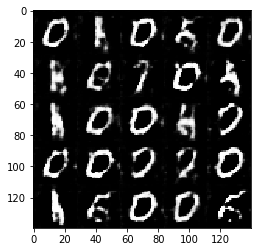

Epoch 2/2... Discriminator Loss: 0.7170... Generator Loss: 2.2283
Epoch 2/2... Discriminator Loss: 0.7844... Generator Loss: 1.5821
Epoch 2/2... Discriminator Loss: 0.7549... Generator Loss: 2.5350


IndexError: list index out of range

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
logits shape::: (?, 28, 28, 3)
x3 shape::: (?, 4, 4, 1024)
x3 shape::: (?, 4, 4, 1024)
Epoch 1/5... Discriminator Loss: 1.3035... Generator Loss: 2.3073
Epoch 1/5... Discriminator Loss: 4.0082... Generator Loss: 0.0761
Epoch 1/5... Discriminator Loss: 0.5465... Generator Loss: 3.8452
Epoch 1/5... Discriminator Loss: 0.4534... Generator Loss: 3.6809
Epoch 1/5... Discriminator Loss: 1.5779... Generator Loss: 0.7689
Epoch 1/5... Discriminator Loss: 0.9088... Generator Loss: 1.8305
Epoch 1/5... Discriminator Loss: 1.7038... Generator Loss: 0.4468
Epoch 1/5... Discriminator Loss: 0.5778... Generator Loss: 2.4963
Epoch 1/5... Discriminator Loss: 1.4307... Generator Loss: 2.0978
Epoch 1/5... Discriminator Loss: 0.5797... Generator Loss: 2.2588
logits shape::: (?, 28, 28, 3)


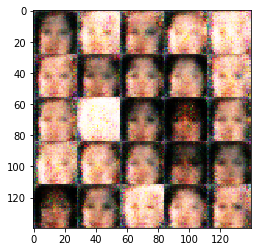

Epoch 1/5... Discriminator Loss: 0.9764... Generator Loss: 0.8607
Epoch 1/5... Discriminator Loss: 1.5836... Generator Loss: 3.1667
Epoch 1/5... Discriminator Loss: 0.9456... Generator Loss: 1.2545
Epoch 1/5... Discriminator Loss: 0.7477... Generator Loss: 1.6726
Epoch 1/5... Discriminator Loss: 0.6037... Generator Loss: 2.3141
Epoch 1/5... Discriminator Loss: 1.0638... Generator Loss: 1.0943
Epoch 1/5... Discriminator Loss: 0.7434... Generator Loss: 2.0033
Epoch 1/5... Discriminator Loss: 0.6943... Generator Loss: 1.8271
Epoch 1/5... Discriminator Loss: 1.8602... Generator Loss: 1.3384
Epoch 1/5... Discriminator Loss: 1.1918... Generator Loss: 1.1100
logits shape::: (?, 28, 28, 3)


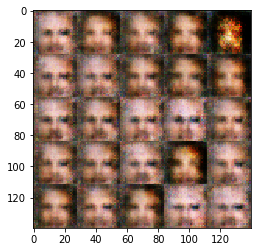

Epoch 1/5... Discriminator Loss: 0.8355... Generator Loss: 2.1139
Epoch 1/5... Discriminator Loss: 1.7138... Generator Loss: 1.0203
Epoch 1/5... Discriminator Loss: 1.1872... Generator Loss: 1.1546
Epoch 1/5... Discriminator Loss: 0.7604... Generator Loss: 1.4085
Epoch 1/5... Discriminator Loss: 1.2303... Generator Loss: 1.9272
Epoch 1/5... Discriminator Loss: 1.8320... Generator Loss: 0.4816
Epoch 1/5... Discriminator Loss: 0.6172... Generator Loss: 1.8535
Epoch 1/5... Discriminator Loss: 2.1204... Generator Loss: 0.7530
Epoch 1/5... Discriminator Loss: 1.8524... Generator Loss: 0.7452
Epoch 1/5... Discriminator Loss: 1.0160... Generator Loss: 1.1882
logits shape::: (?, 28, 28, 3)


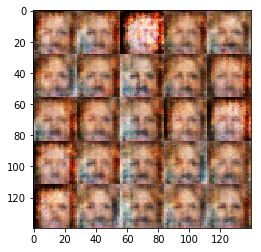

Epoch 1/5... Discriminator Loss: 1.5552... Generator Loss: 2.4336
Epoch 1/5... Discriminator Loss: 2.6083... Generator Loss: 3.6607
Epoch 1/5... Discriminator Loss: 1.1946... Generator Loss: 0.8898
Epoch 1/5... Discriminator Loss: 1.5103... Generator Loss: 1.0941
Epoch 1/5... Discriminator Loss: 1.1745... Generator Loss: 1.8383
Epoch 1/5... Discriminator Loss: 1.2178... Generator Loss: 1.2757
Epoch 1/5... Discriminator Loss: 1.4201... Generator Loss: 0.7153
Epoch 1/5... Discriminator Loss: 1.2649... Generator Loss: 1.2247
Epoch 1/5... Discriminator Loss: 1.3787... Generator Loss: 1.3518
Epoch 1/5... Discriminator Loss: 1.3515... Generator Loss: 1.1570
logits shape::: (?, 28, 28, 3)


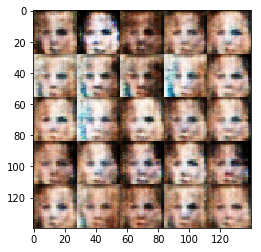

Epoch 1/5... Discriminator Loss: 1.2365... Generator Loss: 0.8786
Epoch 1/5... Discriminator Loss: 1.2129... Generator Loss: 1.3080
Epoch 1/5... Discriminator Loss: 1.4398... Generator Loss: 0.8008
Epoch 1/5... Discriminator Loss: 1.5851... Generator Loss: 0.5224
Epoch 1/5... Discriminator Loss: 1.0581... Generator Loss: 1.2585
Epoch 1/5... Discriminator Loss: 1.3226... Generator Loss: 0.8157
Epoch 1/5... Discriminator Loss: 1.1146... Generator Loss: 1.2930
Epoch 1/5... Discriminator Loss: 1.4844... Generator Loss: 0.4533
Epoch 1/5... Discriminator Loss: 1.3094... Generator Loss: 1.0766
Epoch 1/5... Discriminator Loss: 0.9122... Generator Loss: 1.1715
logits shape::: (?, 28, 28, 3)


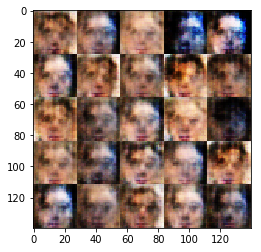

Epoch 1/5... Discriminator Loss: 1.1958... Generator Loss: 1.5480
Epoch 1/5... Discriminator Loss: 1.5582... Generator Loss: 1.3421
Epoch 1/5... Discriminator Loss: 1.2239... Generator Loss: 0.9852
Epoch 1/5... Discriminator Loss: 1.3328... Generator Loss: 0.8562
Epoch 1/5... Discriminator Loss: 1.3170... Generator Loss: 0.8907
Epoch 1/5... Discriminator Loss: 1.3515... Generator Loss: 0.7139
Epoch 1/5... Discriminator Loss: 1.2307... Generator Loss: 1.1733
Epoch 1/5... Discriminator Loss: 1.2483... Generator Loss: 0.9123
Epoch 1/5... Discriminator Loss: 1.2598... Generator Loss: 0.8382
Epoch 1/5... Discriminator Loss: 1.4801... Generator Loss: 1.1045
logits shape::: (?, 28, 28, 3)


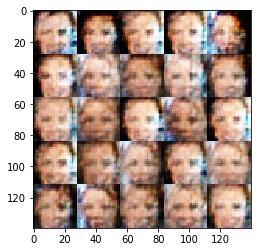

Epoch 1/5... Discriminator Loss: 1.3388... Generator Loss: 0.8534
Epoch 1/5... Discriminator Loss: 1.5584... Generator Loss: 0.9888
Epoch 1/5... Discriminator Loss: 1.3702... Generator Loss: 1.1082
Epoch 1/5... Discriminator Loss: 1.5866... Generator Loss: 0.5912
Epoch 1/5... Discriminator Loss: 1.3985... Generator Loss: 0.9969
Epoch 1/5... Discriminator Loss: 1.3811... Generator Loss: 1.0786
Epoch 1/5... Discriminator Loss: 1.3220... Generator Loss: 1.0714
Epoch 1/5... Discriminator Loss: 1.3278... Generator Loss: 0.9261
Epoch 1/5... Discriminator Loss: 1.5406... Generator Loss: 1.4694
Epoch 1/5... Discriminator Loss: 1.2365... Generator Loss: 1.1131
logits shape::: (?, 28, 28, 3)


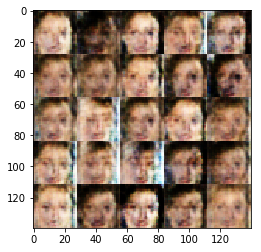

Epoch 1/5... Discriminator Loss: 1.4704... Generator Loss: 0.9205
Epoch 1/5... Discriminator Loss: 1.5296... Generator Loss: 0.8560
Epoch 1/5... Discriminator Loss: 1.3458... Generator Loss: 0.8126
Epoch 1/5... Discriminator Loss: 1.4800... Generator Loss: 0.8293
Epoch 1/5... Discriminator Loss: 1.0250... Generator Loss: 0.8914
Epoch 1/5... Discriminator Loss: 1.3332... Generator Loss: 1.2440
Epoch 1/5... Discriminator Loss: 1.5845... Generator Loss: 0.6047
Epoch 1/5... Discriminator Loss: 1.3170... Generator Loss: 0.6894
Epoch 1/5... Discriminator Loss: 1.1491... Generator Loss: 0.8238
Epoch 1/5... Discriminator Loss: 1.0831... Generator Loss: 0.8835
logits shape::: (?, 28, 28, 3)


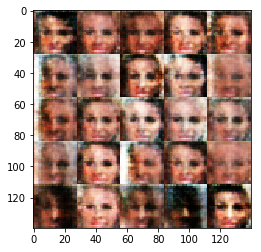

Epoch 1/5... Discriminator Loss: 1.2039... Generator Loss: 1.2976
Epoch 1/5... Discriminator Loss: 1.1480... Generator Loss: 0.7110
Epoch 1/5... Discriminator Loss: 1.1983... Generator Loss: 1.3473
Epoch 1/5... Discriminator Loss: 1.3121... Generator Loss: 0.8823
Epoch 1/5... Discriminator Loss: 1.2647... Generator Loss: 0.7674
Epoch 1/5... Discriminator Loss: 1.4751... Generator Loss: 1.2922
Epoch 1/5... Discriminator Loss: 1.5697... Generator Loss: 0.5930
Epoch 1/5... Discriminator Loss: 1.1896... Generator Loss: 0.8779
Epoch 1/5... Discriminator Loss: 1.0954... Generator Loss: 1.2065
Epoch 1/5... Discriminator Loss: 1.2099... Generator Loss: 0.7349
logits shape::: (?, 28, 28, 3)


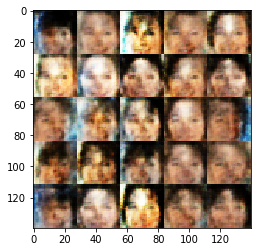

Epoch 1/5... Discriminator Loss: 1.2655... Generator Loss: 1.6059
Epoch 1/5... Discriminator Loss: 1.4860... Generator Loss: 0.9661
Epoch 1/5... Discriminator Loss: 1.2643... Generator Loss: 0.7591
Epoch 1/5... Discriminator Loss: 1.2777... Generator Loss: 1.2183
Epoch 1/5... Discriminator Loss: 1.3724... Generator Loss: 1.6388
Epoch 1/5... Discriminator Loss: 1.2116... Generator Loss: 0.9928
Epoch 1/5... Discriminator Loss: 1.2217... Generator Loss: 0.9083
Epoch 1/5... Discriminator Loss: 1.2530... Generator Loss: 0.9435
Epoch 1/5... Discriminator Loss: 1.3642... Generator Loss: 0.9104
Epoch 1/5... Discriminator Loss: 1.2926... Generator Loss: 0.8738
logits shape::: (?, 28, 28, 3)


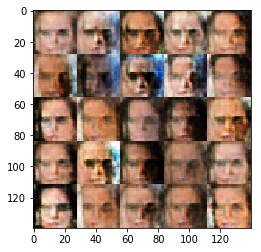

Epoch 1/5... Discriminator Loss: 1.1781... Generator Loss: 1.3447
Epoch 1/5... Discriminator Loss: 1.2951... Generator Loss: 1.2506
Epoch 1/5... Discriminator Loss: 1.0885... Generator Loss: 0.9751
Epoch 1/5... Discriminator Loss: 1.3347... Generator Loss: 1.1724
Epoch 1/5... Discriminator Loss: 1.7412... Generator Loss: 0.7265
Epoch 1/5... Discriminator Loss: 1.2138... Generator Loss: 0.8748
Epoch 1/5... Discriminator Loss: 1.3402... Generator Loss: 1.1904
Epoch 1/5... Discriminator Loss: 1.6267... Generator Loss: 0.6538
Epoch 1/5... Discriminator Loss: 1.1805... Generator Loss: 0.7371
Epoch 1/5... Discriminator Loss: 1.2109... Generator Loss: 0.8332
logits shape::: (?, 28, 28, 3)


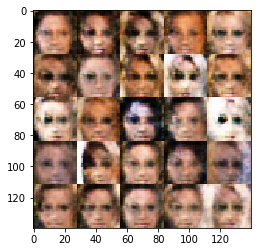

Epoch 1/5... Discriminator Loss: 1.4463... Generator Loss: 0.9259
Epoch 1/5... Discriminator Loss: 1.1839... Generator Loss: 1.0359
Epoch 1/5... Discriminator Loss: 1.4302... Generator Loss: 0.8578
Epoch 1/5... Discriminator Loss: 1.3163... Generator Loss: 0.9101
Epoch 1/5... Discriminator Loss: 1.0806... Generator Loss: 0.9617
Epoch 1/5... Discriminator Loss: 1.2598... Generator Loss: 1.0173
Epoch 1/5... Discriminator Loss: 1.2963... Generator Loss: 0.8924
Epoch 1/5... Discriminator Loss: 1.2177... Generator Loss: 0.9024
Epoch 1/5... Discriminator Loss: 1.2678... Generator Loss: 1.2631
Epoch 1/5... Discriminator Loss: 1.4666... Generator Loss: 0.6264
logits shape::: (?, 28, 28, 3)


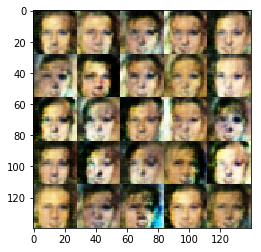

Epoch 1/5... Discriminator Loss: 1.2235... Generator Loss: 1.1304
Epoch 1/5... Discriminator Loss: 1.3722... Generator Loss: 0.8645
Epoch 1/5... Discriminator Loss: 1.3094... Generator Loss: 1.0608
Epoch 1/5... Discriminator Loss: 1.2845... Generator Loss: 1.3293
Epoch 1/5... Discriminator Loss: 1.2775... Generator Loss: 0.9989
Epoch 1/5... Discriminator Loss: 1.4057... Generator Loss: 1.3921
Epoch 1/5... Discriminator Loss: 1.3174... Generator Loss: 1.0130
Epoch 1/5... Discriminator Loss: 1.2738... Generator Loss: 0.8737
Epoch 1/5... Discriminator Loss: 1.4401... Generator Loss: 0.7431
Epoch 1/5... Discriminator Loss: 1.1862... Generator Loss: 0.8427
logits shape::: (?, 28, 28, 3)


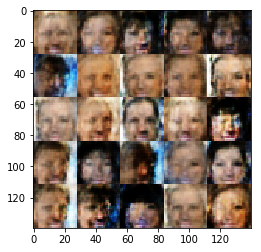

Epoch 1/5... Discriminator Loss: 1.4841... Generator Loss: 0.7507
Epoch 1/5... Discriminator Loss: 1.4725... Generator Loss: 0.6755
Epoch 1/5... Discriminator Loss: 1.4298... Generator Loss: 0.9589
Epoch 1/5... Discriminator Loss: 1.3589... Generator Loss: 0.6212
Epoch 1/5... Discriminator Loss: 1.1464... Generator Loss: 0.9717
Epoch 1/5... Discriminator Loss: 1.4166... Generator Loss: 0.7948
Epoch 1/5... Discriminator Loss: 1.2861... Generator Loss: 1.1814
Epoch 1/5... Discriminator Loss: 1.3310... Generator Loss: 0.8391
Epoch 1/5... Discriminator Loss: 1.4054... Generator Loss: 0.7699
Epoch 1/5... Discriminator Loss: 1.3412... Generator Loss: 0.9585
logits shape::: (?, 28, 28, 3)


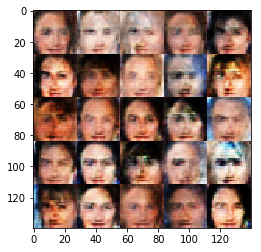

Epoch 1/5... Discriminator Loss: 1.5035... Generator Loss: 0.5814
Epoch 1/5... Discriminator Loss: 1.3289... Generator Loss: 1.0913
Epoch 1/5... Discriminator Loss: 1.2813... Generator Loss: 0.8547
Epoch 1/5... Discriminator Loss: 1.2695... Generator Loss: 1.1602
Epoch 1/5... Discriminator Loss: 1.5150... Generator Loss: 0.5676
Epoch 1/5... Discriminator Loss: 1.3051... Generator Loss: 0.8912
Epoch 1/5... Discriminator Loss: 1.3357... Generator Loss: 0.8859
Epoch 1/5... Discriminator Loss: 1.2691... Generator Loss: 1.0590
Epoch 1/5... Discriminator Loss: 1.2384... Generator Loss: 0.9634
Epoch 1/5... Discriminator Loss: 1.2439... Generator Loss: 0.8078
logits shape::: (?, 28, 28, 3)


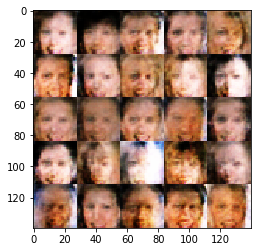

Epoch 1/5... Discriminator Loss: 1.3532... Generator Loss: 1.0803
Epoch 1/5... Discriminator Loss: 1.2380... Generator Loss: 0.8476
Epoch 1/5... Discriminator Loss: 1.4979... Generator Loss: 0.7988
Epoch 1/5... Discriminator Loss: 1.4054... Generator Loss: 1.0812
Epoch 1/5... Discriminator Loss: 1.2523... Generator Loss: 0.8059
Epoch 1/5... Discriminator Loss: 1.8414... Generator Loss: 1.0895
Epoch 1/5... Discriminator Loss: 1.3488... Generator Loss: 0.7334
Epoch 1/5... Discriminator Loss: 1.2696... Generator Loss: 1.0930
Epoch 2/5... Discriminator Loss: 1.2612... Generator Loss: 1.0005
Epoch 2/5... Discriminator Loss: 1.5089... Generator Loss: 0.4837
logits shape::: (?, 28, 28, 3)


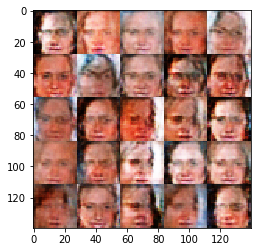

Epoch 2/5... Discriminator Loss: 1.2637... Generator Loss: 1.0714
Epoch 2/5... Discriminator Loss: 1.3170... Generator Loss: 1.0323
Epoch 2/5... Discriminator Loss: 1.2666... Generator Loss: 1.1583
Epoch 2/5... Discriminator Loss: 1.4426... Generator Loss: 0.8486
Epoch 2/5... Discriminator Loss: 1.2416... Generator Loss: 0.6815
Epoch 2/5... Discriminator Loss: 1.0395... Generator Loss: 0.9358
Epoch 2/5... Discriminator Loss: 1.1554... Generator Loss: 0.7193
Epoch 2/5... Discriminator Loss: 1.5808... Generator Loss: 0.7183
Epoch 2/5... Discriminator Loss: 1.3578... Generator Loss: 0.5818
Epoch 2/5... Discriminator Loss: 1.4094... Generator Loss: 0.8661
logits shape::: (?, 28, 28, 3)


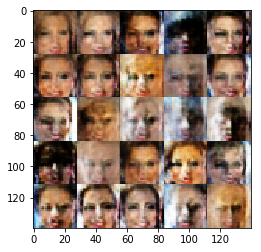

Epoch 2/5... Discriminator Loss: 1.3764... Generator Loss: 1.2160
Epoch 2/5... Discriminator Loss: 1.1858... Generator Loss: 1.0939
Epoch 2/5... Discriminator Loss: 1.1040... Generator Loss: 0.8315
Epoch 2/5... Discriminator Loss: 1.3820... Generator Loss: 1.2758
Epoch 2/5... Discriminator Loss: 1.2279... Generator Loss: 0.9203
Epoch 2/5... Discriminator Loss: 1.1792... Generator Loss: 1.1243
Epoch 2/5... Discriminator Loss: 1.4161... Generator Loss: 1.1855
Epoch 2/5... Discriminator Loss: 0.9967... Generator Loss: 1.1517
Epoch 2/5... Discriminator Loss: 1.1310... Generator Loss: 0.7631
Epoch 2/5... Discriminator Loss: 1.5077... Generator Loss: 1.5396
logits shape::: (?, 28, 28, 3)


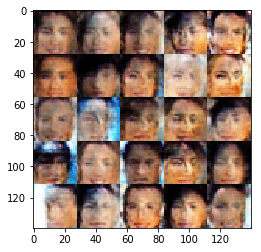

Epoch 2/5... Discriminator Loss: 1.4573... Generator Loss: 1.4666
Epoch 2/5... Discriminator Loss: 1.3044... Generator Loss: 0.6776
Epoch 2/5... Discriminator Loss: 1.9531... Generator Loss: 0.3815
Epoch 2/5... Discriminator Loss: 1.1369... Generator Loss: 1.1309
Epoch 2/5... Discriminator Loss: 1.4654... Generator Loss: 0.8185
Epoch 2/5... Discriminator Loss: 1.0781... Generator Loss: 1.0357
Epoch 2/5... Discriminator Loss: 1.4664... Generator Loss: 0.7426
Epoch 2/5... Discriminator Loss: 1.3952... Generator Loss: 1.4072
Epoch 2/5... Discriminator Loss: 1.5514... Generator Loss: 0.5738
Epoch 2/5... Discriminator Loss: 1.4931... Generator Loss: 0.5086
logits shape::: (?, 28, 28, 3)


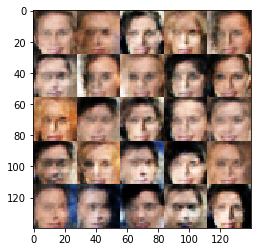

Epoch 2/5... Discriminator Loss: 1.2186... Generator Loss: 0.9028
Epoch 2/5... Discriminator Loss: 1.1959... Generator Loss: 1.4475
Epoch 2/5... Discriminator Loss: 1.2382... Generator Loss: 1.3512
Epoch 2/5... Discriminator Loss: 1.3762... Generator Loss: 0.7226
Epoch 2/5... Discriminator Loss: 1.1245... Generator Loss: 1.4959
Epoch 2/5... Discriminator Loss: 1.3070... Generator Loss: 1.0957
Epoch 2/5... Discriminator Loss: 1.2101... Generator Loss: 0.6255
Epoch 2/5... Discriminator Loss: 1.0364... Generator Loss: 1.0100
Epoch 2/5... Discriminator Loss: 1.0960... Generator Loss: 0.9192
Epoch 2/5... Discriminator Loss: 1.2595... Generator Loss: 1.2053
logits shape::: (?, 28, 28, 3)


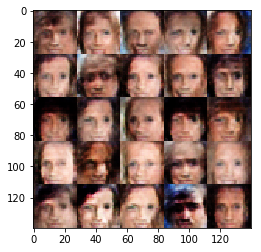

Epoch 2/5... Discriminator Loss: 1.0635... Generator Loss: 0.8976
Epoch 2/5... Discriminator Loss: 1.1402... Generator Loss: 1.0479
Epoch 2/5... Discriminator Loss: 1.2978... Generator Loss: 0.8994
Epoch 2/5... Discriminator Loss: 1.2632... Generator Loss: 1.0252
Epoch 2/5... Discriminator Loss: 1.1166... Generator Loss: 0.8197
Epoch 2/5... Discriminator Loss: 1.2662... Generator Loss: 0.9281
Epoch 2/5... Discriminator Loss: 1.1670... Generator Loss: 0.8507
Epoch 2/5... Discriminator Loss: 1.4594... Generator Loss: 0.8341
Epoch 2/5... Discriminator Loss: 1.1422... Generator Loss: 1.2461
Epoch 2/5... Discriminator Loss: 1.5970... Generator Loss: 1.0835
logits shape::: (?, 28, 28, 3)


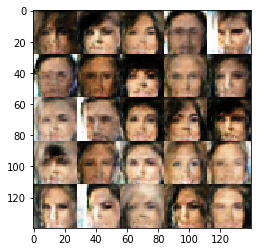

Epoch 2/5... Discriminator Loss: 1.3782... Generator Loss: 0.9651
Epoch 2/5... Discriminator Loss: 1.3134... Generator Loss: 1.9778
Epoch 2/5... Discriminator Loss: 1.4579... Generator Loss: 0.6730
Epoch 2/5... Discriminator Loss: 1.2656... Generator Loss: 0.8009
Epoch 2/5... Discriminator Loss: 1.2696... Generator Loss: 0.8477
Epoch 2/5... Discriminator Loss: 1.5922... Generator Loss: 0.4883
Epoch 2/5... Discriminator Loss: 1.1093... Generator Loss: 1.6623
Epoch 2/5... Discriminator Loss: 1.1723... Generator Loss: 0.9171
Epoch 2/5... Discriminator Loss: 1.3513... Generator Loss: 1.8101
Epoch 2/5... Discriminator Loss: 1.6583... Generator Loss: 0.5553
logits shape::: (?, 28, 28, 3)


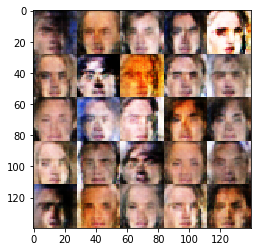

Epoch 2/5... Discriminator Loss: 1.0989... Generator Loss: 1.0249
Epoch 2/5... Discriminator Loss: 1.5219... Generator Loss: 0.4965
Epoch 2/5... Discriminator Loss: 1.1638... Generator Loss: 0.8006
Epoch 2/5... Discriminator Loss: 1.3777... Generator Loss: 1.7643
Epoch 2/5... Discriminator Loss: 1.2259... Generator Loss: 0.9846
Epoch 2/5... Discriminator Loss: 1.1575... Generator Loss: 1.4824
Epoch 2/5... Discriminator Loss: 2.0509... Generator Loss: 2.7859
Epoch 2/5... Discriminator Loss: 1.1321... Generator Loss: 0.8250
Epoch 2/5... Discriminator Loss: 1.3365... Generator Loss: 0.7804
Epoch 2/5... Discriminator Loss: 1.0325... Generator Loss: 1.0955
logits shape::: (?, 28, 28, 3)


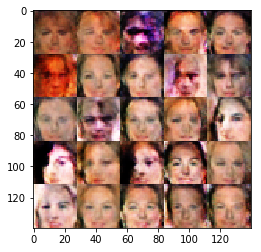

Epoch 2/5... Discriminator Loss: 1.0989... Generator Loss: 0.8967
Epoch 2/5... Discriminator Loss: 1.1643... Generator Loss: 0.8044
Epoch 2/5... Discriminator Loss: 1.1754... Generator Loss: 0.9841
Epoch 2/5... Discriminator Loss: 1.1085... Generator Loss: 1.2003
Epoch 2/5... Discriminator Loss: 1.2616... Generator Loss: 1.5068
Epoch 2/5... Discriminator Loss: 1.0924... Generator Loss: 1.2508
Epoch 2/5... Discriminator Loss: 1.1055... Generator Loss: 1.5627
Epoch 2/5... Discriminator Loss: 1.0993... Generator Loss: 0.8848
Epoch 2/5... Discriminator Loss: 1.3261... Generator Loss: 1.1233
Epoch 2/5... Discriminator Loss: 1.9606... Generator Loss: 0.5012
logits shape::: (?, 28, 28, 3)


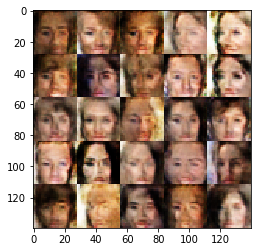

Epoch 2/5... Discriminator Loss: 1.3803... Generator Loss: 1.2194
Epoch 2/5... Discriminator Loss: 1.1385... Generator Loss: 0.8200
Epoch 2/5... Discriminator Loss: 1.5075... Generator Loss: 0.6076
Epoch 2/5... Discriminator Loss: 1.0568... Generator Loss: 1.1652
Epoch 2/5... Discriminator Loss: 1.5706... Generator Loss: 0.8807
Epoch 2/5... Discriminator Loss: 1.0136... Generator Loss: 1.0122
Epoch 2/5... Discriminator Loss: 1.2032... Generator Loss: 1.0642
Epoch 2/5... Discriminator Loss: 1.0334... Generator Loss: 1.1045
Epoch 2/5... Discriminator Loss: 1.1382... Generator Loss: 1.2552
Epoch 2/5... Discriminator Loss: 1.3140... Generator Loss: 0.7865
logits shape::: (?, 28, 28, 3)


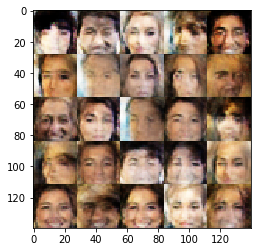

Epoch 2/5... Discriminator Loss: 1.0602... Generator Loss: 0.9760
Epoch 2/5... Discriminator Loss: 1.0840... Generator Loss: 1.4049
Epoch 2/5... Discriminator Loss: 1.1409... Generator Loss: 1.0825
Epoch 2/5... Discriminator Loss: 1.1221... Generator Loss: 1.1231
Epoch 2/5... Discriminator Loss: 1.3203... Generator Loss: 0.5904
Epoch 2/5... Discriminator Loss: 0.9174... Generator Loss: 0.9901
Epoch 2/5... Discriminator Loss: 1.3270... Generator Loss: 1.1304
Epoch 2/5... Discriminator Loss: 1.2328... Generator Loss: 1.2315
Epoch 2/5... Discriminator Loss: 1.3870... Generator Loss: 0.6558
Epoch 2/5... Discriminator Loss: 1.3564... Generator Loss: 1.1063
logits shape::: (?, 28, 28, 3)


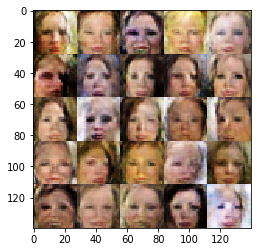

Epoch 2/5... Discriminator Loss: 1.2395... Generator Loss: 0.9520
Epoch 2/5... Discriminator Loss: 1.2875... Generator Loss: 0.7581
Epoch 2/5... Discriminator Loss: 1.2510... Generator Loss: 0.7200
Epoch 2/5... Discriminator Loss: 1.2099... Generator Loss: 0.6066
Epoch 2/5... Discriminator Loss: 1.5405... Generator Loss: 0.6031
Epoch 2/5... Discriminator Loss: 1.0740... Generator Loss: 0.9308
Epoch 2/5... Discriminator Loss: 1.1912... Generator Loss: 1.1277
Epoch 2/5... Discriminator Loss: 1.3572... Generator Loss: 2.3107
Epoch 2/5... Discriminator Loss: 1.2115... Generator Loss: 0.6953
Epoch 2/5... Discriminator Loss: 1.1213... Generator Loss: 1.3929
logits shape::: (?, 28, 28, 3)


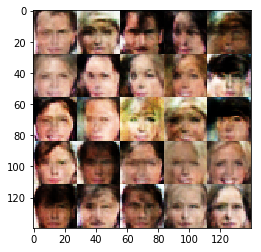

Epoch 2/5... Discriminator Loss: 1.2102... Generator Loss: 1.0260
Epoch 2/5... Discriminator Loss: 1.0311... Generator Loss: 1.0413
Epoch 2/5... Discriminator Loss: 0.9977... Generator Loss: 1.1058
Epoch 2/5... Discriminator Loss: 1.0793... Generator Loss: 0.9067
Epoch 2/5... Discriminator Loss: 1.0283... Generator Loss: 1.8255
Epoch 2/5... Discriminator Loss: 1.3088... Generator Loss: 1.4174
Epoch 2/5... Discriminator Loss: 1.1613... Generator Loss: 1.0062
Epoch 2/5... Discriminator Loss: 1.0793... Generator Loss: 1.2554
Epoch 2/5... Discriminator Loss: 1.0897... Generator Loss: 1.5711
Epoch 2/5... Discriminator Loss: 1.5938... Generator Loss: 0.5555
logits shape::: (?, 28, 28, 3)


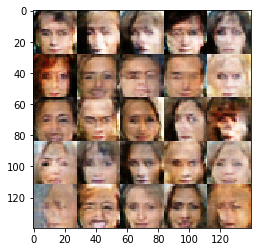

Epoch 2/5... Discriminator Loss: 2.1717... Generator Loss: 3.3985
Epoch 2/5... Discriminator Loss: 0.9490... Generator Loss: 1.1344
Epoch 2/5... Discriminator Loss: 1.0788... Generator Loss: 1.3236
Epoch 2/5... Discriminator Loss: 1.1267... Generator Loss: 1.1559
Epoch 2/5... Discriminator Loss: 1.0981... Generator Loss: 0.9002
Epoch 2/5... Discriminator Loss: 1.0202... Generator Loss: 0.9330
Epoch 2/5... Discriminator Loss: 1.2164... Generator Loss: 1.2504
Epoch 2/5... Discriminator Loss: 1.0274... Generator Loss: 1.3298
Epoch 2/5... Discriminator Loss: 0.9592... Generator Loss: 0.9832
Epoch 2/5... Discriminator Loss: 1.1608... Generator Loss: 1.0654
logits shape::: (?, 28, 28, 3)


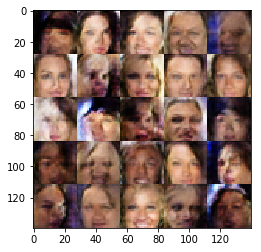

Epoch 2/5... Discriminator Loss: 0.9532... Generator Loss: 1.7166
Epoch 2/5... Discriminator Loss: 0.8368... Generator Loss: 1.6251
Epoch 2/5... Discriminator Loss: 1.5954... Generator Loss: 0.5759
Epoch 2/5... Discriminator Loss: 0.8191... Generator Loss: 1.3488
Epoch 2/5... Discriminator Loss: 1.7144... Generator Loss: 0.4355
Epoch 2/5... Discriminator Loss: 1.8343... Generator Loss: 0.3682
Epoch 2/5... Discriminator Loss: 1.4359... Generator Loss: 0.6181
Epoch 2/5... Discriminator Loss: 1.0532... Generator Loss: 1.1329
Epoch 2/5... Discriminator Loss: 1.1240... Generator Loss: 0.9074
Epoch 2/5... Discriminator Loss: 1.2058... Generator Loss: 1.2132
logits shape::: (?, 28, 28, 3)


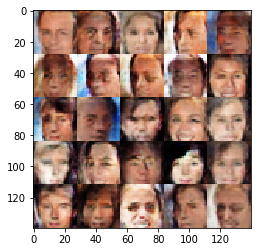

Epoch 2/5... Discriminator Loss: 0.9739... Generator Loss: 1.2566
Epoch 2/5... Discriminator Loss: 1.3691... Generator Loss: 0.7641
Epoch 2/5... Discriminator Loss: 1.5605... Generator Loss: 0.4783
Epoch 2/5... Discriminator Loss: 0.7665... Generator Loss: 1.2830
Epoch 2/5... Discriminator Loss: 0.9432... Generator Loss: 1.4018
Epoch 2/5... Discriminator Loss: 0.8922... Generator Loss: 1.3401
Epoch 2/5... Discriminator Loss: 1.0913... Generator Loss: 1.0849
Epoch 2/5... Discriminator Loss: 1.3473... Generator Loss: 0.7076
Epoch 2/5... Discriminator Loss: 1.0504... Generator Loss: 1.2068
Epoch 2/5... Discriminator Loss: 0.9565... Generator Loss: 0.9664
logits shape::: (?, 28, 28, 3)


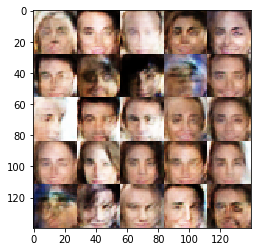

Epoch 2/5... Discriminator Loss: 0.9695... Generator Loss: 1.1288
Epoch 2/5... Discriminator Loss: 0.7202... Generator Loss: 1.7369
Epoch 2/5... Discriminator Loss: 1.0656... Generator Loss: 1.3917
Epoch 2/5... Discriminator Loss: 1.3068... Generator Loss: 0.5352
Epoch 2/5... Discriminator Loss: 0.9039... Generator Loss: 1.1115
Epoch 2/5... Discriminator Loss: 1.4380... Generator Loss: 1.4221
Epoch 3/5... Discriminator Loss: 0.8269... Generator Loss: 1.2338
Epoch 3/5... Discriminator Loss: 0.9486... Generator Loss: 1.5536
Epoch 3/5... Discriminator Loss: 0.9983... Generator Loss: 1.4308
Epoch 3/5... Discriminator Loss: 1.1655... Generator Loss: 0.6712
logits shape::: (?, 28, 28, 3)


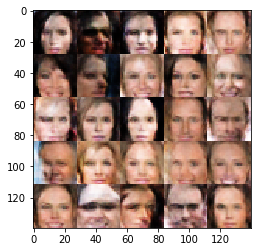

Epoch 3/5... Discriminator Loss: 0.8251... Generator Loss: 1.5864
Epoch 3/5... Discriminator Loss: 1.7579... Generator Loss: 3.6813
Epoch 3/5... Discriminator Loss: 1.1863... Generator Loss: 1.9659
Epoch 3/5... Discriminator Loss: 1.2063... Generator Loss: 0.8417
Epoch 3/5... Discriminator Loss: 1.1067... Generator Loss: 0.9605
Epoch 3/5... Discriminator Loss: 0.9093... Generator Loss: 1.3296
Epoch 3/5... Discriminator Loss: 0.9871... Generator Loss: 1.1807
Epoch 3/5... Discriminator Loss: 1.0459... Generator Loss: 1.1049
Epoch 3/5... Discriminator Loss: 1.1487... Generator Loss: 1.0521
Epoch 3/5... Discriminator Loss: 0.9241... Generator Loss: 1.2008
logits shape::: (?, 28, 28, 3)


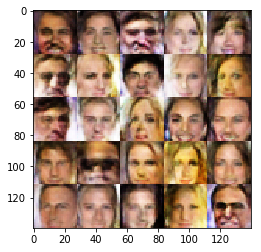

Epoch 3/5... Discriminator Loss: 0.9885... Generator Loss: 0.9373
Epoch 3/5... Discriminator Loss: 0.8602... Generator Loss: 1.5802
Epoch 3/5... Discriminator Loss: 0.9383... Generator Loss: 0.9203
Epoch 3/5... Discriminator Loss: 1.0422... Generator Loss: 1.8788
Epoch 3/5... Discriminator Loss: 0.9876... Generator Loss: 1.6590
Epoch 3/5... Discriminator Loss: 1.0648... Generator Loss: 1.2566
Epoch 3/5... Discriminator Loss: 1.1003... Generator Loss: 0.8269
Epoch 3/5... Discriminator Loss: 0.9795... Generator Loss: 1.4616
Epoch 3/5... Discriminator Loss: 0.7353... Generator Loss: 1.4882
Epoch 3/5... Discriminator Loss: 1.0555... Generator Loss: 1.5093
logits shape::: (?, 28, 28, 3)


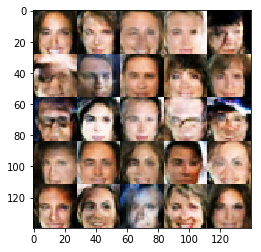

Epoch 3/5... Discriminator Loss: 0.8802... Generator Loss: 1.0514
Epoch 3/5... Discriminator Loss: 0.9726... Generator Loss: 2.3868
Epoch 3/5... Discriminator Loss: 0.9090... Generator Loss: 1.5067
Epoch 3/5... Discriminator Loss: 0.7415... Generator Loss: 1.1072
Epoch 3/5... Discriminator Loss: 0.9582... Generator Loss: 1.0722
Epoch 3/5... Discriminator Loss: 0.7779... Generator Loss: 1.3564
Epoch 3/5... Discriminator Loss: 1.1322... Generator Loss: 1.1601
Epoch 3/5... Discriminator Loss: 0.7198... Generator Loss: 1.9128
Epoch 3/5... Discriminator Loss: 1.4436... Generator Loss: 1.2254
Epoch 3/5... Discriminator Loss: 1.0012... Generator Loss: 1.2682
logits shape::: (?, 28, 28, 3)


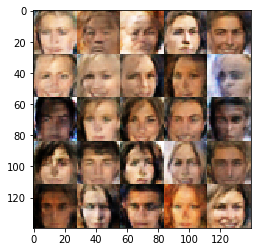

Epoch 3/5... Discriminator Loss: 0.9576... Generator Loss: 1.1110
Epoch 3/5... Discriminator Loss: 0.7628... Generator Loss: 1.7147
Epoch 3/5... Discriminator Loss: 1.0885... Generator Loss: 1.1641
Epoch 3/5... Discriminator Loss: 1.1750... Generator Loss: 0.7054
Epoch 3/5... Discriminator Loss: 0.9673... Generator Loss: 1.0459
Epoch 3/5... Discriminator Loss: 0.9936... Generator Loss: 1.3779
Epoch 3/5... Discriminator Loss: 0.8431... Generator Loss: 1.5027
Epoch 3/5... Discriminator Loss: 0.8290... Generator Loss: 1.9971
Epoch 3/5... Discriminator Loss: 0.9589... Generator Loss: 1.1706
Epoch 3/5... Discriminator Loss: 0.9837... Generator Loss: 2.8417
logits shape::: (?, 28, 28, 3)


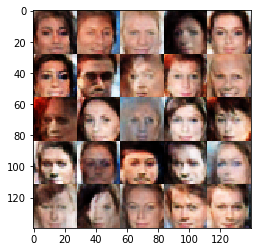

Epoch 3/5... Discriminator Loss: 1.0790... Generator Loss: 1.2241
Epoch 3/5... Discriminator Loss: 1.0319... Generator Loss: 0.8687
Epoch 3/5... Discriminator Loss: 0.8131... Generator Loss: 1.6581
Epoch 3/5... Discriminator Loss: 0.7866... Generator Loss: 1.8501
Epoch 3/5... Discriminator Loss: 0.9866... Generator Loss: 1.8452
Epoch 3/5... Discriminator Loss: 0.7633... Generator Loss: 1.6210
Epoch 3/5... Discriminator Loss: 1.0020... Generator Loss: 0.9993
Epoch 3/5... Discriminator Loss: 0.8943... Generator Loss: 1.2833
Epoch 3/5... Discriminator Loss: 0.9971... Generator Loss: 1.5853
Epoch 3/5... Discriminator Loss: 0.8864... Generator Loss: 1.1501
logits shape::: (?, 28, 28, 3)


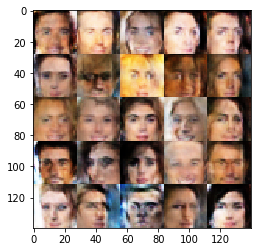

Epoch 3/5... Discriminator Loss: 1.2803... Generator Loss: 0.5561
Epoch 3/5... Discriminator Loss: 1.1240... Generator Loss: 0.7768
Epoch 3/5... Discriminator Loss: 0.8141... Generator Loss: 1.1112
Epoch 3/5... Discriminator Loss: 0.8150... Generator Loss: 1.9768
Epoch 3/5... Discriminator Loss: 0.9373... Generator Loss: 1.0651
Epoch 3/5... Discriminator Loss: 0.7456... Generator Loss: 1.6513
Epoch 3/5... Discriminator Loss: 0.8321... Generator Loss: 1.9567
Epoch 3/5... Discriminator Loss: 1.7714... Generator Loss: 0.4008
Epoch 3/5... Discriminator Loss: 0.7510... Generator Loss: 1.8871
Epoch 3/5... Discriminator Loss: 0.8074... Generator Loss: 1.3468
logits shape::: (?, 28, 28, 3)


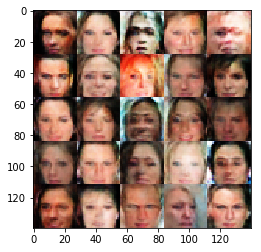

Epoch 3/5... Discriminator Loss: 1.4755... Generator Loss: 0.6442
Epoch 3/5... Discriminator Loss: 0.9398... Generator Loss: 1.6872
Epoch 3/5... Discriminator Loss: 0.7577... Generator Loss: 2.3641
Epoch 3/5... Discriminator Loss: 1.0725... Generator Loss: 1.5624
Epoch 3/5... Discriminator Loss: 0.8319... Generator Loss: 1.6213
Epoch 3/5... Discriminator Loss: 1.1859... Generator Loss: 0.8718
Epoch 3/5... Discriminator Loss: 0.7947... Generator Loss: 1.8083
Epoch 3/5... Discriminator Loss: 1.3755... Generator Loss: 0.5080
Epoch 3/5... Discriminator Loss: 1.3234... Generator Loss: 0.6686
Epoch 3/5... Discriminator Loss: 0.8733... Generator Loss: 1.7319
logits shape::: (?, 28, 28, 3)


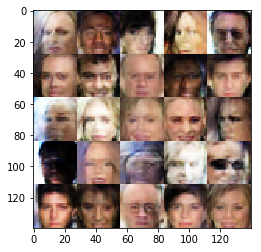

Epoch 3/5... Discriminator Loss: 1.6008... Generator Loss: 4.1116
Epoch 3/5... Discriminator Loss: 0.8808... Generator Loss: 1.4142
Epoch 3/5... Discriminator Loss: 1.0536... Generator Loss: 2.2109
Epoch 3/5... Discriminator Loss: 1.0586... Generator Loss: 2.3197
Epoch 3/5... Discriminator Loss: 0.7266... Generator Loss: 1.9857
Epoch 3/5... Discriminator Loss: 2.0421... Generator Loss: 0.4500
Epoch 3/5... Discriminator Loss: 0.7786... Generator Loss: 2.4790
Epoch 3/5... Discriminator Loss: 1.2599... Generator Loss: 2.5974
Epoch 3/5... Discriminator Loss: 0.9509... Generator Loss: 1.3837
Epoch 3/5... Discriminator Loss: 0.5679... Generator Loss: 2.0827
logits shape::: (?, 28, 28, 3)


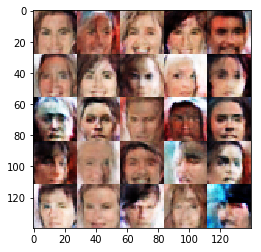

Epoch 3/5... Discriminator Loss: 0.8822... Generator Loss: 1.0749
Epoch 3/5... Discriminator Loss: 0.9881... Generator Loss: 1.8548
Epoch 3/5... Discriminator Loss: 0.6133... Generator Loss: 1.3417
Epoch 3/5... Discriminator Loss: 0.8911... Generator Loss: 1.3152
Epoch 3/5... Discriminator Loss: 1.3483... Generator Loss: 0.8424
Epoch 3/5... Discriminator Loss: 1.1325... Generator Loss: 1.0838
Epoch 3/5... Discriminator Loss: 0.9264... Generator Loss: 1.0974
Epoch 3/5... Discriminator Loss: 1.8848... Generator Loss: 0.3413
Epoch 3/5... Discriminator Loss: 1.1519... Generator Loss: 1.1921
Epoch 3/5... Discriminator Loss: 0.9221... Generator Loss: 2.3473
logits shape::: (?, 28, 28, 3)


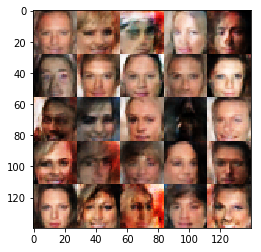

Epoch 3/5... Discriminator Loss: 0.6482... Generator Loss: 2.5187
Epoch 3/5... Discriminator Loss: 0.6589... Generator Loss: 1.5199
Epoch 3/5... Discriminator Loss: 0.6693... Generator Loss: 1.5017
Epoch 3/5... Discriminator Loss: 1.1278... Generator Loss: 0.7297
Epoch 3/5... Discriminator Loss: 1.2117... Generator Loss: 0.8941
Epoch 3/5... Discriminator Loss: 1.0976... Generator Loss: 0.9063
Epoch 3/5... Discriminator Loss: 0.8748... Generator Loss: 1.7525
Epoch 3/5... Discriminator Loss: 0.9773... Generator Loss: 1.7297
Epoch 3/5... Discriminator Loss: 0.8434... Generator Loss: 1.3414
Epoch 3/5... Discriminator Loss: 1.2369... Generator Loss: 0.8432
logits shape::: (?, 28, 28, 3)


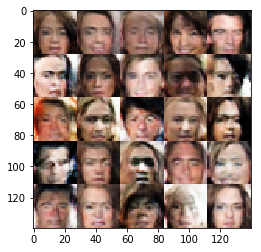

Epoch 3/5... Discriminator Loss: 0.7687... Generator Loss: 1.9387
Epoch 3/5... Discriminator Loss: 0.6740... Generator Loss: 1.5554
Epoch 3/5... Discriminator Loss: 0.7214... Generator Loss: 1.3708
Epoch 3/5... Discriminator Loss: 0.7562... Generator Loss: 1.5605
Epoch 3/5... Discriminator Loss: 0.5774... Generator Loss: 2.3108
Epoch 3/5... Discriminator Loss: 1.2743... Generator Loss: 0.8207
Epoch 3/5... Discriminator Loss: 1.5221... Generator Loss: 3.9630
Epoch 3/5... Discriminator Loss: 0.6656... Generator Loss: 1.6144
Epoch 3/5... Discriminator Loss: 1.4095... Generator Loss: 0.7367
Epoch 3/5... Discriminator Loss: 0.9797... Generator Loss: 1.1759
logits shape::: (?, 28, 28, 3)


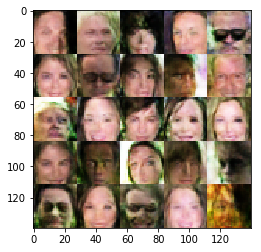

Epoch 3/5... Discriminator Loss: 0.6519... Generator Loss: 1.8224
Epoch 3/5... Discriminator Loss: 1.3383... Generator Loss: 0.7763
Epoch 3/5... Discriminator Loss: 0.7774... Generator Loss: 1.4527
Epoch 3/5... Discriminator Loss: 0.8491... Generator Loss: 1.1943
Epoch 3/5... Discriminator Loss: 1.0390... Generator Loss: 3.3542
Epoch 3/5... Discriminator Loss: 0.8680... Generator Loss: 1.4129
Epoch 3/5... Discriminator Loss: 0.5852... Generator Loss: 1.7784
Epoch 3/5... Discriminator Loss: 1.1254... Generator Loss: 0.9789
Epoch 3/5... Discriminator Loss: 1.0518... Generator Loss: 0.9071
Epoch 3/5... Discriminator Loss: 0.8320... Generator Loss: 1.6453
logits shape::: (?, 28, 28, 3)


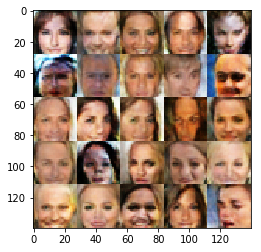

Epoch 3/5... Discriminator Loss: 0.8201... Generator Loss: 1.7971
Epoch 3/5... Discriminator Loss: 0.8027... Generator Loss: 1.6464
Epoch 3/5... Discriminator Loss: 0.8819... Generator Loss: 1.5316
Epoch 3/5... Discriminator Loss: 0.8641... Generator Loss: 1.1370
Epoch 3/5... Discriminator Loss: 0.4954... Generator Loss: 2.9948
Epoch 3/5... Discriminator Loss: 0.7755... Generator Loss: 1.7769
Epoch 3/5... Discriminator Loss: 1.0120... Generator Loss: 1.2476
Epoch 3/5... Discriminator Loss: 0.8574... Generator Loss: 1.3138
Epoch 3/5... Discriminator Loss: 1.1867... Generator Loss: 0.8521
Epoch 3/5... Discriminator Loss: 0.7782... Generator Loss: 2.2033
logits shape::: (?, 28, 28, 3)


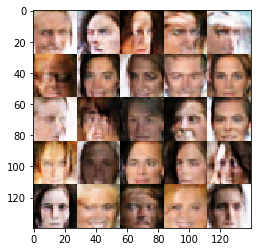

Epoch 3/5... Discriminator Loss: 0.8156... Generator Loss: 1.4471
Epoch 3/5... Discriminator Loss: 0.6890... Generator Loss: 2.6508
Epoch 3/5... Discriminator Loss: 0.7062... Generator Loss: 2.4391
Epoch 3/5... Discriminator Loss: 0.6786... Generator Loss: 1.6539
Epoch 3/5... Discriminator Loss: 0.6293... Generator Loss: 2.1482
Epoch 3/5... Discriminator Loss: 0.5619... Generator Loss: 1.8035
Epoch 3/5... Discriminator Loss: 0.8780... Generator Loss: 1.9063
Epoch 3/5... Discriminator Loss: 1.3541... Generator Loss: 0.7835
Epoch 3/5... Discriminator Loss: 0.5415... Generator Loss: 3.0234
Epoch 3/5... Discriminator Loss: 1.0062... Generator Loss: 2.8397
logits shape::: (?, 28, 28, 3)


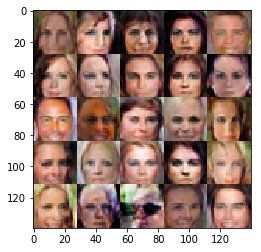

Epoch 3/5... Discriminator Loss: 0.5293... Generator Loss: 3.0007
Epoch 3/5... Discriminator Loss: 1.0867... Generator Loss: 0.7984
Epoch 3/5... Discriminator Loss: 0.7982... Generator Loss: 1.3365
Epoch 3/5... Discriminator Loss: 0.8182... Generator Loss: 2.6950
Epoch 3/5... Discriminator Loss: 1.0847... Generator Loss: 0.8532
Epoch 3/5... Discriminator Loss: 1.1053... Generator Loss: 4.4810
Epoch 3/5... Discriminator Loss: 0.7272... Generator Loss: 1.8447
Epoch 3/5... Discriminator Loss: 0.6859... Generator Loss: 1.6037
Epoch 3/5... Discriminator Loss: 0.5392... Generator Loss: 2.0304
Epoch 3/5... Discriminator Loss: 0.7246... Generator Loss: 1.2768
logits shape::: (?, 28, 28, 3)


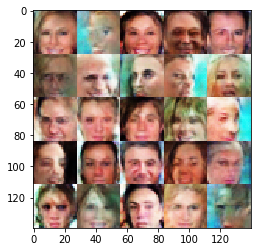

Epoch 3/5... Discriminator Loss: 0.6749... Generator Loss: 1.7845
Epoch 3/5... Discriminator Loss: 0.9610... Generator Loss: 1.6475
Epoch 3/5... Discriminator Loss: 0.6901... Generator Loss: 2.4103
Epoch 3/5... Discriminator Loss: 0.6985... Generator Loss: 2.5177
Epoch 4/5... Discriminator Loss: 0.6776... Generator Loss: 1.5260
Epoch 4/5... Discriminator Loss: 1.1184... Generator Loss: 0.9297
Epoch 4/5... Discriminator Loss: 1.0671... Generator Loss: 0.8856
Epoch 4/5... Discriminator Loss: 0.7158... Generator Loss: 1.4367
Epoch 4/5... Discriminator Loss: 0.7065... Generator Loss: 1.8626
Epoch 4/5... Discriminator Loss: 1.3640... Generator Loss: 0.5771
logits shape::: (?, 28, 28, 3)


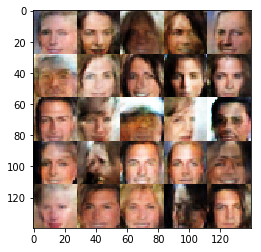

Epoch 4/5... Discriminator Loss: 0.7689... Generator Loss: 1.3235
Epoch 4/5... Discriminator Loss: 0.6099... Generator Loss: 2.0715
Epoch 4/5... Discriminator Loss: 0.6147... Generator Loss: 1.5691
Epoch 4/5... Discriminator Loss: 1.0743... Generator Loss: 1.0122
Epoch 4/5... Discriminator Loss: 0.9626... Generator Loss: 0.9888
Epoch 4/5... Discriminator Loss: 0.8645... Generator Loss: 1.0721
Epoch 4/5... Discriminator Loss: 1.2563... Generator Loss: 0.6247
Epoch 4/5... Discriminator Loss: 1.1033... Generator Loss: 0.6739
Epoch 4/5... Discriminator Loss: 0.9277... Generator Loss: 1.4393
Epoch 4/5... Discriminator Loss: 0.7858... Generator Loss: 1.3849
logits shape::: (?, 28, 28, 3)


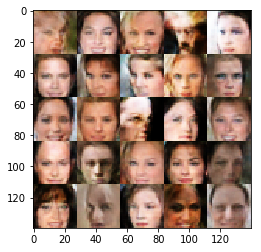

Epoch 4/5... Discriminator Loss: 0.6896... Generator Loss: 1.5780
Epoch 4/5... Discriminator Loss: 1.0049... Generator Loss: 1.2711
Epoch 4/5... Discriminator Loss: 1.2729... Generator Loss: 0.7646
Epoch 4/5... Discriminator Loss: 0.7673... Generator Loss: 2.9850
Epoch 4/5... Discriminator Loss: 0.5335... Generator Loss: 3.0349
Epoch 4/5... Discriminator Loss: 0.8999... Generator Loss: 1.1602
Epoch 4/5... Discriminator Loss: 0.8397... Generator Loss: 1.0611
Epoch 4/5... Discriminator Loss: 0.9469... Generator Loss: 1.3291
Epoch 4/5... Discriminator Loss: 0.6017... Generator Loss: 2.3441
Epoch 4/5... Discriminator Loss: 0.7834... Generator Loss: 2.2504
logits shape::: (?, 28, 28, 3)


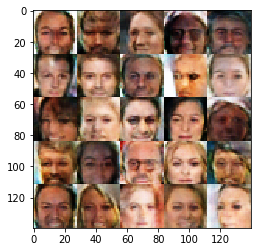

Epoch 4/5... Discriminator Loss: 1.2955... Generator Loss: 0.7065
Epoch 4/5... Discriminator Loss: 1.9717... Generator Loss: 0.2025
Epoch 4/5... Discriminator Loss: 0.5798... Generator Loss: 2.5052
Epoch 4/5... Discriminator Loss: 0.6165... Generator Loss: 2.5988
Epoch 4/5... Discriminator Loss: 0.7558... Generator Loss: 3.9616
Epoch 4/5... Discriminator Loss: 0.8453... Generator Loss: 2.4779
Epoch 4/5... Discriminator Loss: 1.1624... Generator Loss: 1.0429
Epoch 4/5... Discriminator Loss: 0.7321... Generator Loss: 2.1606
Epoch 4/5... Discriminator Loss: 1.0134... Generator Loss: 0.9166
Epoch 4/5... Discriminator Loss: 1.0004... Generator Loss: 1.9815
logits shape::: (?, 28, 28, 3)


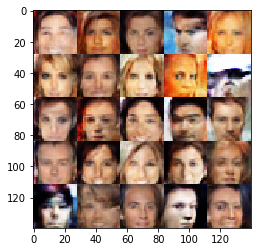

Epoch 4/5... Discriminator Loss: 0.5841... Generator Loss: 1.1699
Epoch 4/5... Discriminator Loss: 1.3649... Generator Loss: 0.5974
Epoch 4/5... Discriminator Loss: 0.5634... Generator Loss: 3.2989
Epoch 4/5... Discriminator Loss: 0.6730... Generator Loss: 1.5229
Epoch 4/5... Discriminator Loss: 0.8026... Generator Loss: 2.7865
Epoch 4/5... Discriminator Loss: 1.0619... Generator Loss: 0.9758
Epoch 4/5... Discriminator Loss: 0.8038... Generator Loss: 2.4570
Epoch 4/5... Discriminator Loss: 0.6849... Generator Loss: 1.7065
Epoch 4/5... Discriminator Loss: 2.0539... Generator Loss: 0.3886
Epoch 4/5... Discriminator Loss: 0.5393... Generator Loss: 2.8232
logits shape::: (?, 28, 28, 3)


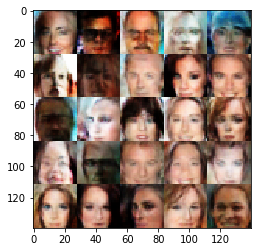

Epoch 4/5... Discriminator Loss: 0.6803... Generator Loss: 2.1182
Epoch 4/5... Discriminator Loss: 0.7439... Generator Loss: 1.5983
Epoch 4/5... Discriminator Loss: 0.5790... Generator Loss: 2.4183
Epoch 4/5... Discriminator Loss: 1.0164... Generator Loss: 0.8828
Epoch 4/5... Discriminator Loss: 1.1577... Generator Loss: 2.9351
Epoch 4/5... Discriminator Loss: 1.1074... Generator Loss: 3.5977
Epoch 4/5... Discriminator Loss: 0.8196... Generator Loss: 2.1534
Epoch 4/5... Discriminator Loss: 0.6098... Generator Loss: 1.8737
Epoch 4/5... Discriminator Loss: 0.5486... Generator Loss: 2.2202
Epoch 4/5... Discriminator Loss: 1.9185... Generator Loss: 0.3657
logits shape::: (?, 28, 28, 3)


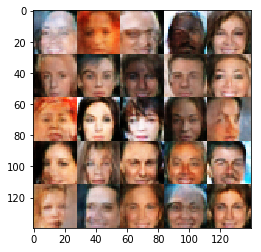

Epoch 4/5... Discriminator Loss: 0.4907... Generator Loss: 2.8958
Epoch 4/5... Discriminator Loss: 0.4504... Generator Loss: 3.1495
Epoch 4/5... Discriminator Loss: 0.5632... Generator Loss: 2.4615
Epoch 4/5... Discriminator Loss: 1.3333... Generator Loss: 5.6287
Epoch 4/5... Discriminator Loss: 1.6950... Generator Loss: 3.1007
Epoch 4/5... Discriminator Loss: 0.4874... Generator Loss: 3.2377
Epoch 4/5... Discriminator Loss: 0.8045... Generator Loss: 1.3828
logits shape::: (?, 28, 28, 3)


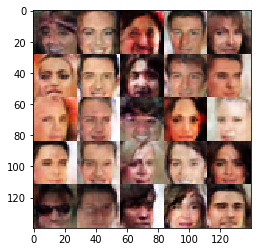

Epoch 4/5... Discriminator Loss: 0.5765... Generator Loss: 2.4990
Epoch 4/5... Discriminator Loss: 0.9044... Generator Loss: 1.7187
Epoch 4/5... Discriminator Loss: 0.5747... Generator Loss: 1.9384
Epoch 4/5... Discriminator Loss: 0.6555... Generator Loss: 2.7967
Epoch 4/5... Discriminator Loss: 1.1974... Generator Loss: 0.7623
Epoch 4/5... Discriminator Loss: 0.5808... Generator Loss: 1.8972
Epoch 4/5... Discriminator Loss: 0.9894... Generator Loss: 1.0451
Epoch 4/5... Discriminator Loss: 0.6939... Generator Loss: 1.5701
Epoch 4/5... Discriminator Loss: 0.5263... Generator Loss: 3.4996
Epoch 4/5... Discriminator Loss: 0.9454... Generator Loss: 1.2181
logits shape::: (?, 28, 28, 3)


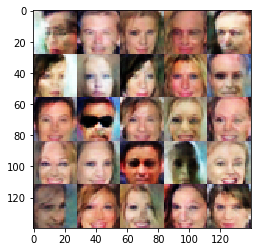

Epoch 4/5... Discriminator Loss: 0.5583... Generator Loss: 2.4839
Epoch 4/5... Discriminator Loss: 0.5213... Generator Loss: 3.6786
Epoch 4/5... Discriminator Loss: 0.7590... Generator Loss: 4.0090
Epoch 4/5... Discriminator Loss: 0.6620... Generator Loss: 2.2257
Epoch 4/5... Discriminator Loss: 0.4650... Generator Loss: 2.8114
Epoch 4/5... Discriminator Loss: 1.5154... Generator Loss: 4.3099
Epoch 4/5... Discriminator Loss: 0.7595... Generator Loss: 3.3542
Epoch 4/5... Discriminator Loss: 1.0349... Generator Loss: 4.0170
Epoch 4/5... Discriminator Loss: 0.9698... Generator Loss: 2.8058
Epoch 4/5... Discriminator Loss: 1.0835... Generator Loss: 1.5722
logits shape::: (?, 28, 28, 3)


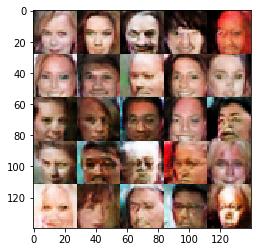

Epoch 4/5... Discriminator Loss: 0.5365... Generator Loss: 2.9970
Epoch 4/5... Discriminator Loss: 0.8985... Generator Loss: 2.2699
Epoch 4/5... Discriminator Loss: 1.0412... Generator Loss: 3.4527
Epoch 4/5... Discriminator Loss: 1.3932... Generator Loss: 4.5526
Epoch 4/5... Discriminator Loss: 0.6238... Generator Loss: 3.8732
Epoch 4/5... Discriminator Loss: 0.5725... Generator Loss: 2.3395
Epoch 4/5... Discriminator Loss: 0.4769... Generator Loss: 3.0115
Epoch 4/5... Discriminator Loss: 1.1526... Generator Loss: 1.0030
Epoch 4/5... Discriminator Loss: 0.4760... Generator Loss: 2.0170
Epoch 4/5... Discriminator Loss: 0.7911... Generator Loss: 2.1364
Epoch 4/5... Discriminator Loss: 1.0520... Generator Loss: 1.1680
Epoch 4/5... Discriminator Loss: 0.9282... Generator Loss: 1.0570
Epoch 4/5... Discriminator Loss: 0.6597... Generator Loss: 1.6447
Epoch 4/5... Discriminator Loss: 0.5709... Generator Loss: 2.7283
Epoch 4/5... Discriminator Loss: 1.1883... Generator Loss: 3.3705
Epoch 4/5.

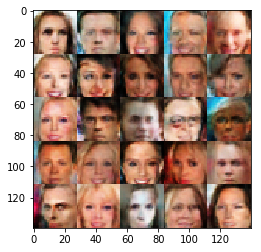

Epoch 4/5... Discriminator Loss: 0.6864... Generator Loss: 2.4429
Epoch 4/5... Discriminator Loss: 0.7157... Generator Loss: 1.8257
Epoch 4/5... Discriminator Loss: 0.6341... Generator Loss: 1.7295
Epoch 4/5... Discriminator Loss: 1.1581... Generator Loss: 1.3401
Epoch 4/5... Discriminator Loss: 0.4442... Generator Loss: 3.7296
Epoch 4/5... Discriminator Loss: 0.5867... Generator Loss: 1.7754
Epoch 4/5... Discriminator Loss: 0.7259... Generator Loss: 3.5837
Epoch 4/5... Discriminator Loss: 0.6350... Generator Loss: 1.7421
Epoch 4/5... Discriminator Loss: 0.4893... Generator Loss: 3.0935
Epoch 4/5... Discriminator Loss: 0.4170... Generator Loss: 3.0637
logits shape::: (?, 28, 28, 3)


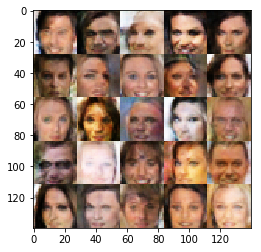

Epoch 4/5... Discriminator Loss: 0.5712... Generator Loss: 2.8977
Epoch 4/5... Discriminator Loss: 0.5365... Generator Loss: 3.3956
Epoch 4/5... Discriminator Loss: 0.4744... Generator Loss: 3.3874
Epoch 4/5... Discriminator Loss: 0.5117... Generator Loss: 2.4704


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.